In [ ]:
import cirq
import stim
import stimcirq

In [2]:
distances = [3, 5, 7]                       # Color code distance.
nshots = 100_000                        # Number of samples/shots
depths = range(10, 600, 50)

noise_rate = 1e-3
noise = cirq.depolarize
simulator = stimcirq.StimSampler()

In [3]:
import dataclasses


@dataclasses.dataclass
class Tile:
    qubits: list
    color: str


def make_color_code_tiles(*, base_data_width):
    if not (base_data_width % 2 == 1 and base_data_width >= 3):
        raise ValueError(f"{base_data_width=} wasn't an odd number at least as large as 3.")
    w = base_data_width * 2 - 1

    def is_in_bounds(q: complex) -> bool:

        if q.imag < 0:

            return False
        if q.imag * 2 > q.real * 3:

            return False
        if q.imag * 2 > (w - q.real) * 3:

            return False
        return True


    tiles = []
    hexagon_offsets = [-1, +1j, +1j + 1, +2, -1j + 1, -1j]
    for x in range(1, w, 2):
        for y in range((x // 2) % 2, w, 2):
            q = x + 1j * y

            tile = Tile(
                color=['red', 'green', 'blue'][y % 3],

            
                qubits=[
                    q + d
                    for d in hexagon_offsets
                    if is_in_bounds(q + d)
                ],
            )

            if len(tile.qubits) in [4, 6]:
                tiles.append(tile)

    return tiles

def get_stabilizer_generators(distance: int):
    tiles = make_color_code_tiles(base_data_width=distance)
    all_qubits = {q for tile in tiles for q in tile.qubits}

    # Only difference here is with the chromobius notebook that we rever
    sorted_qubits = reversed(sorted(all_qubits, key=lambda q: (q.imag, q.real)))
    q2i = {q: i for i, q in enumerate(sorted_qubits)}

    sorted_tiles = []
    for tile in tiles:
        sorted_tiles.append([q2i[q] for q in tile.qubits])

    stabilizers_x = []
    stabilizers_z = []
    for tile in sorted_tiles:
        stab_x = ""
        stab_z = ""
        for i in range(int((3*distance**2+1)/4)):
            if i in tile:
                stab_x+="X"
                stab_z+="Z"
            else:
                stab_x+="I"
                stab_z+="I"
        stabilizers_x.append(stab_x)
        stabilizers_z.append(stab_z)

    return stabilizers_x + stabilizers_z

def stabilizers_to_encoder(stabilizers) -> stim.Circuit:
    
    tableau = stim.Tableau.from_stabilizers(
        stabilizers,
        allow_underconstrained=True,
    )
    # Note: Look at https://github.com/quantumlib/Stim/blob/main/doc/python_api_reference_vDev.md
    # For the different method of encoding

    return tableau.to_circuit(method='graph_state')

## Unmitigated

In [4]:
unmit_evs = []
for depth in depths:
    c = cirq.Circuit([cirq.X.on(cirq.LineQubit(0))]*depth).with_noise(noise(noise_rate))
    c.append(cirq.measure(cirq.LineQubit(0), key="m"))
    ev = simulator.run(c, repetitions=nshots).histogram(key="m")[0] / nshots
    print(ev)
    unmit_evs.append(ev)

0.99334
0.96096
0.93004
0.90412
0.87964
0.85471
0.82824
0.81025
0.78969
0.77166
0.75379
0.73635


## Mitigated

In [5]:
def expectation(counts, logical0, logical1):
    # From YLF
    p0 = 0.0
    p1 = 0.0
    for state in logical0:
        if state in counts:
            p0 += counts[state]
    for state in logical1:
        if state in counts:
            p1 += counts[state]
    obs_value = (p0-p1)/(p0+p1) if p0+p1 > 0 else None
    return obs_value

In [6]:
all_mit_evs = []
for distance in distances:
    generator_strs = get_stabilizer_generators(distance)
    n = len(generator_strs[0])
    qreg = cirq.LineQubit.range(n)

    encoding_circuit = stimcirq.stim_circuit_to_cirq_circuit(stabilizers_to_encoder([stim.PauliString(s) for s in generator_strs]))

    encoding0 = encoding_circuit + [cirq.measure(qreg, key="m")]
    logical0 = simulator.run(encoding0, repetitions=100*2**(sum(sum(range(3+d)) for d in range((distance-3)//2+1)))).histogram(key='m').keys()
    print(f"{len(logical0)} code words for distance {distance}")

    # encoding1 = encoding_circuit + cirq.X.on_each(qreg)
    # encoding1.append(cirq.measure(qreg, key='m'))
    # logical1_ = simulator.run(encoding1, repetitions=nshots).histogram(key='m').keys()

    logical1 = set()
    for cw in logical0:
        logical1.add(int("".join(["0" if ch=="1" else "1" for ch in ["0"]*(n-len(bin(cw)[2:])) + list(bin(cw)[2:])]), 2))
    # print(logical0)
    # print(logical1)
    # print(logical1_)

    mit_evs = []

    for depth in depths:
        noisy_circuit = encoding_circuit.copy()
        for _ in range(depth):
            noisy_circuit.append(cirq.X.on_each(qreg))
        noisy_circuit = noisy_circuit.with_noise(noise(noise_rate))
        noisy_circuit.append(cirq.measure(qreg, key="m"))

        counts = simulator.run(noisy_circuit, repetitions=nshots).histogram(key='m')
        ev = expectation(counts, logical0, logical1)
        print(ev)
        mit_evs.append(ev)
    
    all_mit_evs.append(mit_evs)







8 code words for distance 3
0.9997763263845397
0.9977060049516723
0.9918677996142418
0.9770762630466799
0.955781788266749
0.9201440825422021
0.8729783037475345
0.8178479618068307
0.7567580013815335
0.6790455038479417
0.6052246368652179
0.5257153097186548
512 code words for distance 5
0.9985279561432451
0.9957693368895429
0.9924658095160102
0.9838846480067854
0.9792989884733004
0.9453338539632956
0.9175757575757576
0.8542056074766355
0.779891304347826
0.6708407871198568
0.5650319829424307
0.3676092544987147
262144 code words for distance 7
1.0
0.9984276729559748
1.0
0.9877300613496932
1.0
0.8947368421052632
0.8333333333333334
0.3333333333333333
1.0
0.0
0.0
0.3333333333333333


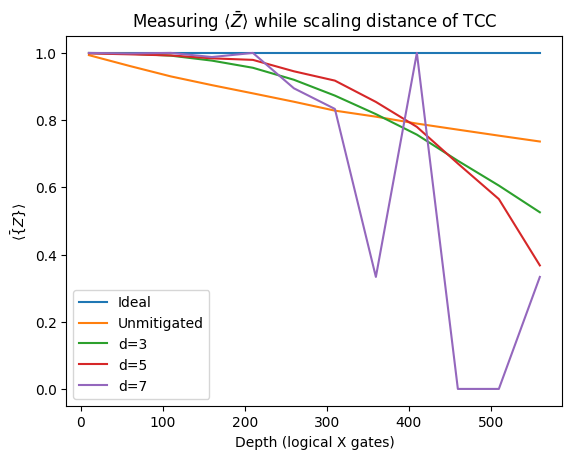

In [8]:
import matplotlib.pyplot as plt

plt.plot(depths, [1.0]*len(depths), label="Ideal")
plt.plot(depths, unmit_evs, label="Unmitigated")

for i, d in enumerate(distances):
    plt.plot(depths, all_mit_evs[i], label=f"d={d}")

plt.title("Measuring $\\langle \\bar{Z}\\rangle$ while scaling distance of TCC")
plt.ylabel("$\\langle \\bar\{Z\}\\rangle$")
plt.xlabel("Depth (logical X gates)")
plt.legend()